# quantify degree of geostrophy with instantaneous fields

Xiaolong initial [notebook](https://github.com/xy6g13/equinox_working/blob/master/sandbox/Reconstruction/Geostrophy%20metric.ipynb)

Horizontal momentum equations leads to:
\begin{align}
-f v_a & = -\partial_t u - (\mathbf{u}\cdot\nabla) u + \mathcal{F}_u  \\
f u_a & = -\partial_t v - (\mathbf{u}\cdot\nabla) v + \mathcal{F}_v 
\end{align}
In terms of variance:
\begin{align}
f^2 \langle v_a^2 \rangle & = \langle\partial_t u^2\rangle 
+ \langle ( (\mathbf{u}\cdot\nabla) u )^2 \rangle 
+ \langle \mathcal{F}_u^2 \rangle 
+ 2 \langle \partial_t u (\mathbf{u}\cdot\nabla) u \rangle
- 2 \langle \mathcal{F}_u \partial_t u  \rangle
- 2 \langle \mathcal{F}_u (\mathbf{u}\cdot\nabla) u \rangle
\\
f^2 \langle u_a^2 \rangle & = \langle\partial_t v^2\rangle 
+ \langle ((\mathbf{u}\cdot\nabla) v)^2 \rangle 
+ \langle \mathcal{F}_v^2 \rangle 
+ 2 \langle \partial_t v (\mathbf{u}\cdot\nabla) v \rangle
- 2 \langle \mathcal{F}_v \partial_t v  \rangle
- 2 \langle \mathcal{F}_v (\mathbf{u}\cdot\nabla) v \rangle
\end{align}




In [1]:
import os, sys, shutil
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn import linear_model

import xgcm

from mitequinox.utils import *
from mitequinox.dynamic import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
#cluster = PBSCluster(cores=1, processes=24, walltime='01:00:00', memory='40GB')
#cluster = PBSCluster(cores=1)
cluster = PBSCluster(cores=8, processes=1,memory='40GB')
#w = cluster.scale(40)
w = cluster.scale(2) # postprocessing

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.135.39.91:44005 Dashboard: http://10.135.39.91:8787/status,Cluster Workers: 2 Cores: 16 Memory: 80.00 GB


In [7]:
#print(cluster.job_script())
#cluster.close()

---
# load data


In [6]:
ds_var = xr.open_zarr(work_data_dir+'spectra/%s_variance_per_band.zarr'%('SSUV'))

In [7]:
print(ds_var.band)

<xarray.DataArray 'band' (band: 5)>
array(['semidiurnal', 'diurnal', 'inertial', 'subdiurnal', 'high'],
      dtype=object)
Coordinates:
  * band     (band) object 'semidiurnal' 'diurnal' ... 'subdiurnal' 'high'


In [8]:
dsu = xr.concat([xr.open_zarr(work_data_dir+'mbal/%sgeo_f%02d_rms.zarr'%('u',face)) 
               for face in range(13)],dim='face').rename({'diff':'udiff'})
dsv = xr.concat([xr.open_zarr(work_data_dir+'mbal/%sgeo_f%02d_rms.zarr'%('v',face)) 
               for face in range(13)],dim='face').rename({'diff':'vdiff'})
ds = xr.merge([dsu,dsv, ds_var])
ds = ds.assign_coords(f=2*omega_earth*np.sin(np.deg2rad(ds.YC))) # at center points
#
ds['u_rms'] = ds.vgeo_coriolis_linear/np.abs(ds.f)
ds['v_rms'] = ds.ugeo_coriolis_linear/np.abs(ds.f)
ds['uv_low_rms'] = np.sqrt(ds.u_rms**2+ds.v_rms**2-ds.uv_variance.sel(band='high'))
#
ds['u_ageo_rms'] = ds.vdiff/np.abs(ds.f)
ds['v_ageo_rms'] = ds.udiff/np.abs(ds.f)
# mask some points
ds = ds.where(ds.Depth>500.).where(np.abs(ds.YC)<60.).where(np.abs(ds.YC)>5.)
#
ds = ds.isel(i=slice(0,None,8),j=slice(0,None,8)).persist()
print(ds)

<xarray.Dataset>
Dimensions:               (band: 5, face: 13, i: 540, j: 540)
Coordinates:
  * i                     (i) int64 0 8 16 24 32 40 ... 4280 4288 4296 4304 4312
  * j                     (j) int64 0 8 16 24 32 40 ... 4280 4288 4296 4304 4312
    CS                    (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
    Depth                 (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
    SN                    (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
    XC                    (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
    YC                    (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
  * face                  (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * band                  (band) object 'semidiurnal' 'diurnal' ... 'high'
    mask                  (face, j, i) float64 dask.array<shape=(13, 540, 540)

### utils

In [9]:
def uniplot(X, xbins, log=False):
    x = X.values.flatten()
    if log:
        x = np.log10(x)
        lxbins=np.arange(*xbins)
    else:
        lxbins=np.arange(0.,*xbins)
    #
    ax = sns.distplot(x).set(xlim=(lxbins[0],lxbins[-1]))
    #
    return ax

def jointplot(X, Y, xbins, ybins, face=range(13), log=False):
    x = X.values.flatten()
    y = Y.values.flatten()
    if log:
        x = np.log10(x)
        y = np.log10(y)
        lxbins=np.arange(*xbins)
        lybins=np.arange(*ybins)        
    else:
        lxbins=np.arange(0.,*xbins)
        lybins=np.arange(0.,*ybins)
    g = sns.JointGrid(x, y, xlim=(lxbins[0],lxbins[-1]),ylim=(lybins[0],lybins[-1]))
    #
    sns.kdeplot(x, color='.5', clip=(lxbins[0],lxbins[-1]), ax=g.ax_marg_x, vertical=False)
    sns.kdeplot(y, color='.5', clip=(lybins[0],lybins[-1]), ax=g.ax_marg_y, vertical=True)
    #
    g = g.plot_joint(plt.hexbin, cmap=cm.deep, extent=[lxbins[0], lxbins[-1], lybins[0], lybins[-1]])
    #g = g.plot_joint(sns.regplot)
    #
    #if log:
    #    g.set_axis_labels(bandx+' log10 [cm²/s²]', bandy+' log10 [cm²/s²]')
    #else:
    #    g.set_axis_labels(bandx+' [cm²/s²]', bandy+' [cm²/s²]')
    return g

### overview maps

{'fig': <Figure size 1080x1080 with 2 Axes>,
 'ax': <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x2b8ec186d3c8>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x2b8ec237acf8>}

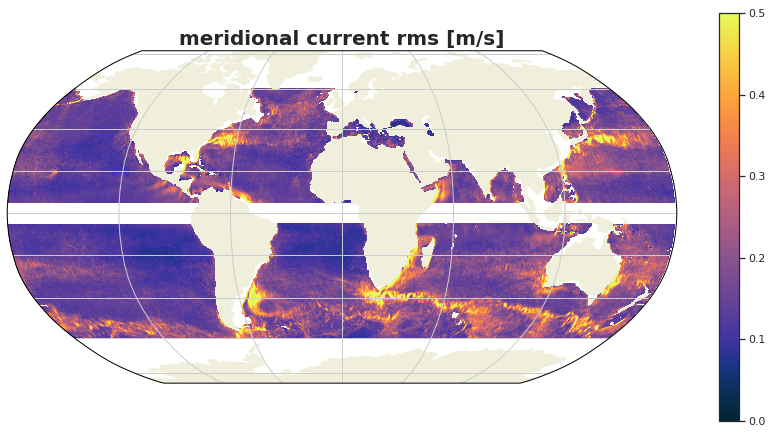

In [10]:
plot_pretty(ds.v_rms, title='meridional current rms [m/s]',
            vmin=0., vmax=.5, cmap=cm.thermal, ignore_face=[6],
            colorbar=True, colorbar_kwargs={'shrink':.5})

{'fig': <Figure size 1080x1080 with 2 Axes>,
 'ax': <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x2b8f5e87f518>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x2b8f5ffae9b0>}

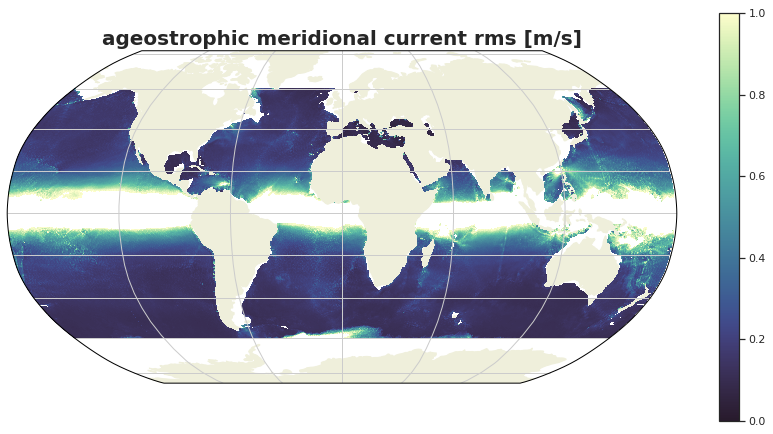

In [11]:
toplt = ds.udiff/np.abs(ds.f)
toplt = toplt.where(toplt<1.)
plot_pretty(toplt, title='ageostrophic meridional current rms [m/s]',
            vmin=0., vmax=1., cmap=cm.deep_r, ignore_face=[6],
            colorbar=True, colorbar_kwargs={'shrink':.5})

{'fig': <Figure size 1080x1080 with 2 Axes>,
 'ax': <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x2b8f8220bc18>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x2b8f88678ac8>}

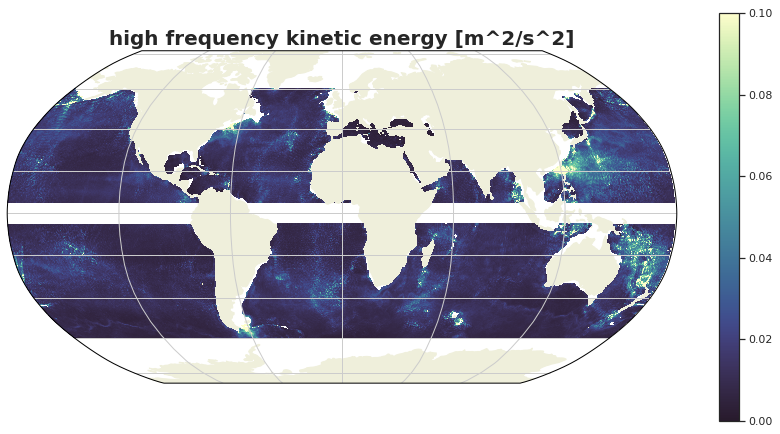

In [15]:
toplt = ds.uv_variance.sel(band='high')
#toplt = toplt.where(toplt<1.)
plot_pretty(toplt, title='high frequency kinetic energy [m^2/s^2]',
            vmin=0., vmax=.1, cmap=cm.deep_r, ignore_face=[6],
            colorbar=True, colorbar_kwargs={'shrink':.5})

In [14]:
ds.band

<xarray.DataArray 'band' (band: 5)>
array(['semidiurnal', 'diurnal', 'inertial', 'subdiurnal', 'high'],
      dtype=object)
Coordinates:
  * band     (band) object 'semidiurnal' 'diurnal' ... 'subdiurnal' 'high'

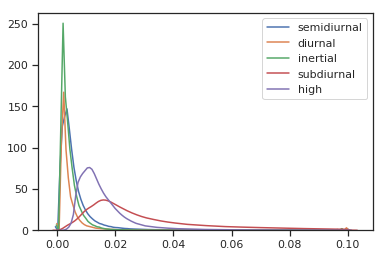

In [17]:

ax=plt.subplot(111)
for band in ds.band:
    toplt = ds.uv_variance.sel(band=band)
    #uniplot(toplt,xbins=(.1,.01))
    X = toplt.values.flatten()
    sns.kdeplot(X,clip=(0,.1),label=band.values, ax=ax)

###  total vs low vs high energies

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


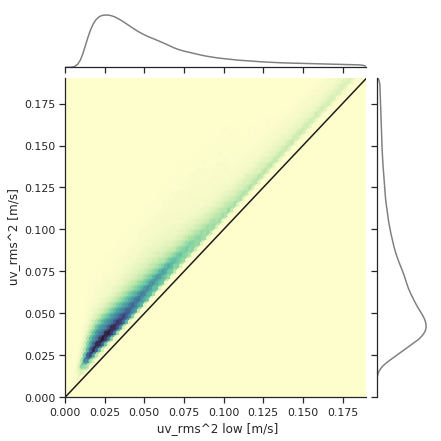

In [10]:
g = jointplot(ds.uv_low_rms**2, ds.u_rms**2+ds.v_rms**2,(.2,.01),(.2,.01), log=False)
g.set_axis_labels(' uv_rms^2 low [m/s]', ' uv_rms^2 [m/s]')
xref = np.array([0.,.5])
g.ax_joint.plot(xref,xref,'k')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


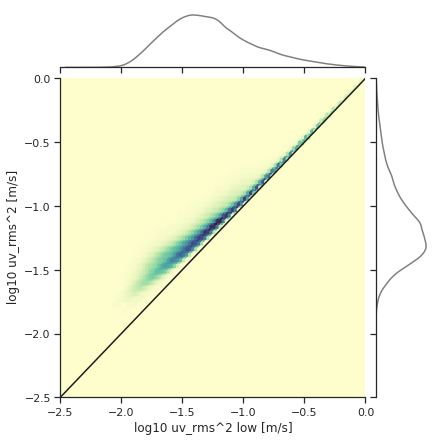

In [11]:
g = jointplot(ds.uv_low_rms**2, ds.u_rms**2+ds.v_rms**2,(-2.5, .1,.1),(-2.5,.1,.1), log=True)
g.set_axis_labels('log10 uv_rms^2 low [m/s]', ' log10 uv_rms^2 [m/s]')
xref = np.array([-2.5,.5])
g.ax_joint.plot(xref,xref,'k')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


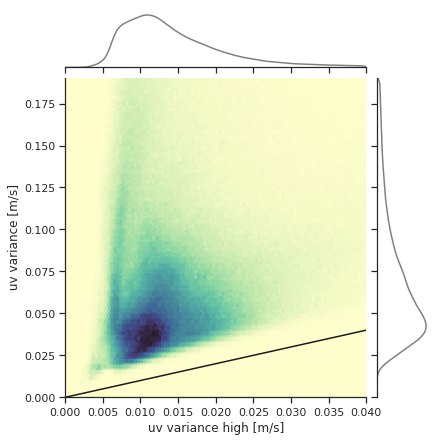

In [12]:
g = jointplot(ds.uv_variance.sel(band='high'), 
              ds.u_rms**2+ds.v_rms**2,(.05,.01),(.2,.01))
g.set_axis_labels('uv variance high [m/s]', ' uv variance [m/s]')
xref = np.array([-2.5,.5])
g.ax_joint.plot(xref,xref,'k')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


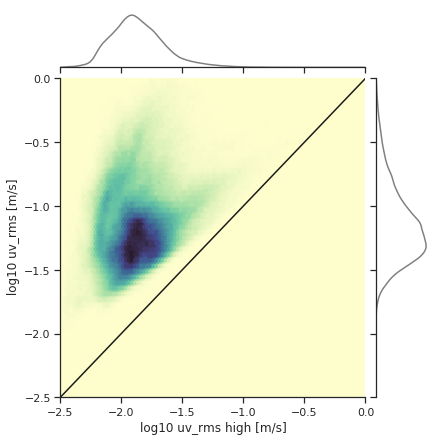

In [13]:
g = jointplot(ds.uv_variance.sel(band='high'), 
              ds.u_rms**2+ds.v_rms**2,(-2.5, .1,.1),(-2.5,.1,.1), log=True)
g.set_axis_labels('log10 uv_rms high [m/s]', ' log10 uv_rms [m/s]')
xref = np.array([-2.5,.5])
g.ax_joint.plot(xref,xref,'k')

### uv ageo vs low, high

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


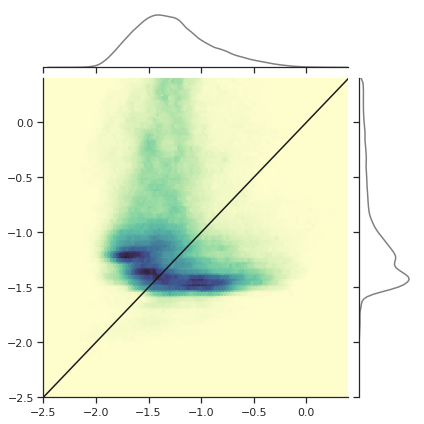

In [24]:
g = jointplot(ds.uv_low_rms**2 , ds.u_ageo_rms**2+ds.v_ageo_rms**2,
              (-2.5, .5,.1),(-2.5,.5,.1), log=True)
xref = np.array([-2.5,.5])
g.ax_joint.plot(xref,xref,'k')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


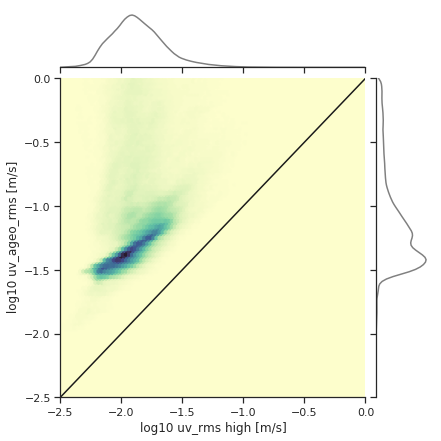

In [25]:
g = jointplot(ds.uv_variance.sel(band='high'), 
              ds.u_ageo_rms**2+ds.v_ageo_rms**2,(-2.5, .1,.1),(-2.5,.1,.1), log=True)
g.set_axis_labels('log10 uv_rms high [m/s]', ' log10 uv_ageo_rms [m/s]')
xref = np.array([-2.5,.5])
g.ax_joint.plot(xref,xref,'k')

### finer frequency decomposition

In [14]:
Xl = [2.*2.*np.pi/86400./np.abs(ds.f)*np.sqrt(ds.uv_variance.sel(band='semidiurnal')),
      2.*np.pi/86400./np.abs(ds.f)*np.sqrt(ds.uv_variance.sel(band='diurnal')),
      np.sqrt(ds.uv_variance.sel(band='inertial')),
      (ds.u_rms**2+ds.v_rms**2)/10e3/np.abs(ds.f)]
#          ds.uv_low_rms**2/10e3/np.abs(ds.f)]

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


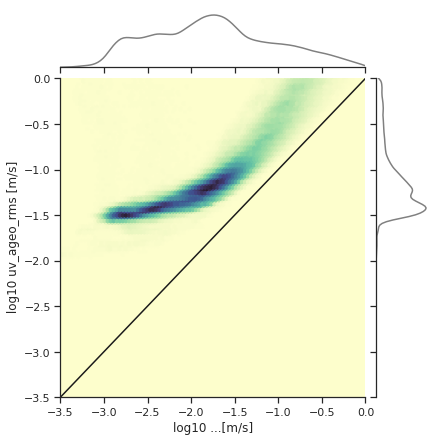

In [17]:
g = jointplot(Xl[0]**2+Xl[1]**2,
              ds.u_ageo_rms**2+ds.v_ageo_rms**2,(-3.5, .1,.1),(-3.5,.1,.1), log=True)
g.set_axis_labels('log10 ...[m/s]', ' log10 uv_ageo_rms [m/s]')
xref = np.array([-3.5,.5])
g.ax_joint.plot(xref,xref,'k')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


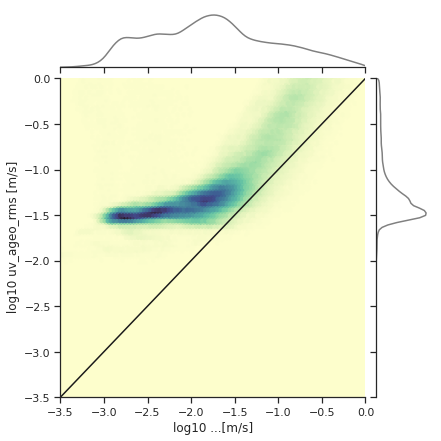

In [30]:
g = jointplot(Xl[0]**2+Xl[1]**2,
              ds.u_ageo_rms**2+ds.v_ageo_rms**2 - (Xl[0]**2+Xl[1]**2),
              (-3.5, .1,.1),(-3.5,.1,.1), log=True)
g.set_axis_labels('log10 ...[m/s]', ' log10 uv_ageo_rms [m/s]')
xref = np.array([-3.5,.5])
g.ax_joint.plot(xref,xref,'k')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


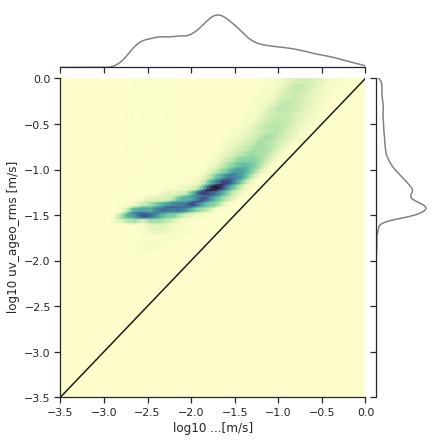

In [20]:
g = jointplot(Xl[0]**2+Xl[1]**2+Xl[2]**2,
              ds.u_ageo_rms**2+ds.v_ageo_rms**2,(-3.5, .1,.1),(-3.5,.1,.1), log=True)
g.set_axis_labels('log10 ...[m/s]', ' log10 uv_ageo_rms [m/s]')
xref = np.array([-3.5,.5])
g.ax_joint.plot(xref,xref,'k')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


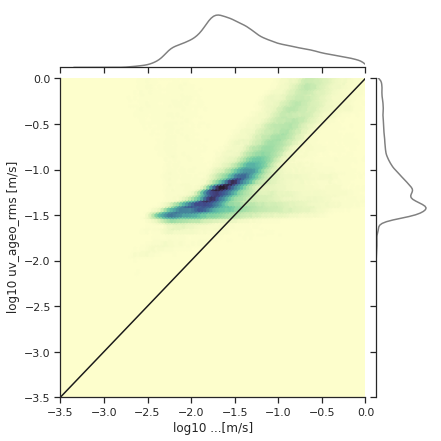

In [23]:
g = jointplot(Xl[0]**2+Xl[1]**2+Xl[2]**2+Xl[3]**2,
              ds.u_ageo_rms**2+ds.v_ageo_rms**2,(-3.5, .1,.1),(-3.5,.1,.1), log=True)
g.set_axis_labels('log10 ...[m/s]', ' log10 uv_ageo_rms [m/s]')
xref = np.array([-3.5,.5])
g.ax_joint.plot(xref,xref,'k')

In [ ]:
g = jointplot(Xl[0]**2+Xl[1]**2+Xl[2]**2+Xl[3]*(Xl[0]+Xl[1]),
              ds.u_ageo_rms**2+ds.v_ageo_rms**2,(-3.5, .1,.1),(-3.5,.1,.1), log=True)
g.set_axis_labels('log10 ...[m/s]', ' log10 uv_ageo_rms [m/s]')
xref = np.array([-3.5,.5])
g.ax_joint.plot(xref,xref,'k')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


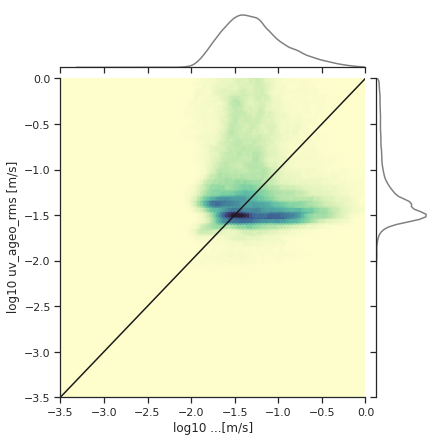

In [25]:
ke_a=ds.u_ageo_rms**2+ds.v_ageo_rms**2
g = jointplot(ds.uv_low_rms**2,
              ke_a-(Xl[0]**2+Xl[1]**2+Xl[2]**2),(-3.5, .1,.1),(-3.5,.1,.1), log=True)
g.set_axis_labels('log10 ...[m/s]', ' log10 uv_ageo_rms [m/s]')
xref = np.array([-3.5,.5])
g.ax_joint.plot(xref,xref,'k')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


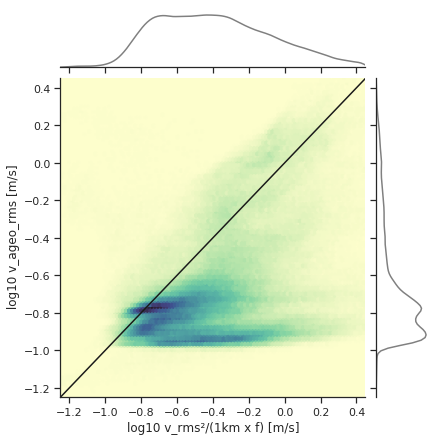

In [39]:
#g = jointplot(ds.vrms*1e2 , (ds.udiff/np.abs(ds.f))*1e2,(0.5, 2.,.1),(0.5,3.,.1), log=True)
g = jointplot(ds.v_rms**2/1e3/np.abs(ds.f) , ds.v_ageo_rms,(-1.25, .5,.1),(-1.25,.5,.1), log=True)
xref = np.array([-2.5,.5])
g.ax_joint.plot(xref,xref,'k')
#g.ax_joint.plot(xref,2*xref,'k')
g.set_axis_labels('log10 v_rms²/(1km x f) [m/s]', ' log10 v_ageo_rms [m/s]')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


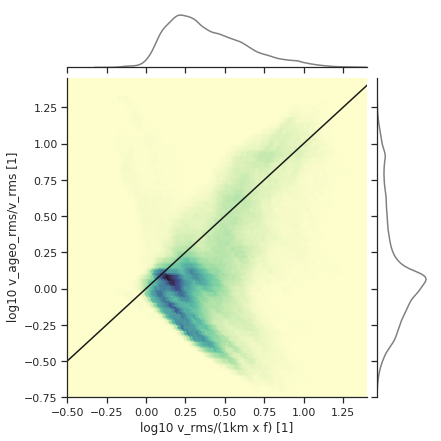

In [38]:
#g = jointplot(ds.vrms*1e2 , (ds.udiff/np.abs(ds.f))*1e2,(0.5, 2.,.1),(0.5,3.,.1), log=True)
g = jointplot(ds.v_rms/1e3/np.abs(ds.f) , ds.v_ageo_rms/ds.v_rms,(-.5, 1.5,.1),(-.75,1.5,.1), log=True)
xref = np.array([-.5,1.5])
g.ax_joint.plot(xref,xref,'k')
#g.ax_joint.plot(xref,2*xref,'k')
g.set_axis_labels('log10 v_rms/(1km x f) [1]', ' log10 v_ageo_rms/v_rms [1]')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


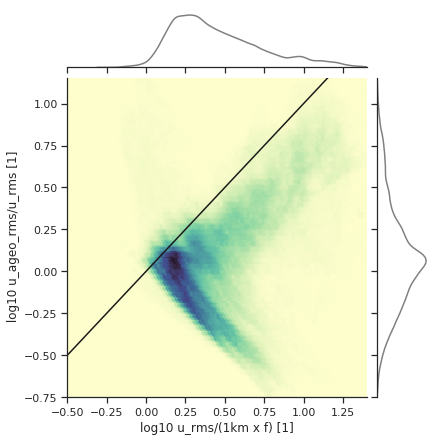

In [37]:
g = jointplot(ds.u_rms/1e3/np.abs(ds.f) , ds.u_ageo_rms/ds.u_rms,(-.5, 1.5,.1),(-.75,1.25,.1), log=True)
xref = np.array([-.5,1.5])
g.ax_joint.plot(xref,xref,'k')
#g.ax_joint.plot(xref,2*xref,'k')
g.set_axis_labels('log10 u_rms/(1km x f) [1]', ' log10 u_ageo_rms/u_rms [1]')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


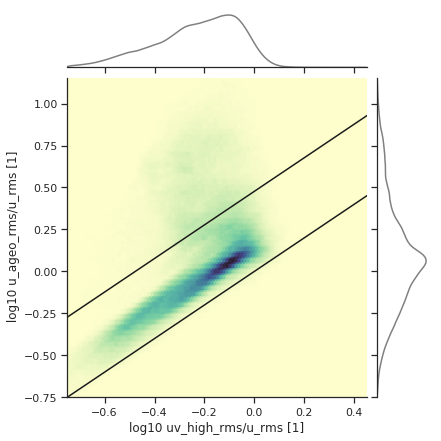

In [15]:
#g = jointplot(ds.u_rms/1e3/ds.f , ds.u_ageo_rms/ds.v_rms,(-.5, 1.5,.1),(-.75,1.5,.1), log=True)
g = jointplot(np.sqrt(ds.uv_variance.sel(band='high'))/ds.u_rms , ds.u_ageo_rms/ds.u_rms,
              (-.75, .5,.1),(-.75,1.25,.1), log=True)
xref = np.array([-2.,.5])
g.ax_joint.plot(xref,xref,'k')
g.ax_joint.plot(xref,xref+np.log10(3),'k')
#g.ax_joint.plot(xref,2*xref,'k')
g.set_axis_labels('log10 uv_high_rms/u_rms [1]', ' log10 u_ageo_rms/u_rms [1]')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


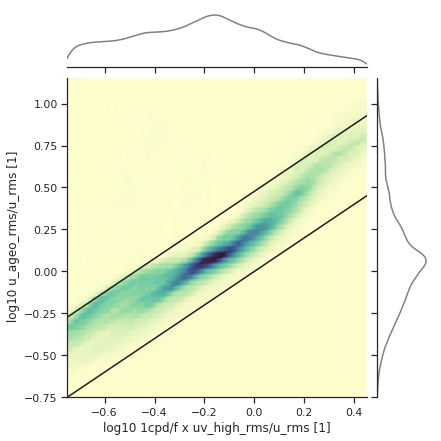

In [36]:
#g = jointplot(ds.u_rms/1e3/ds.f , ds.u_ageo_rms/ds.v_rms,(-.5, 1.5,.1),(-.75,1.5,.1), log=True)
g = jointplot(2.*np.pi/86400./np.abs(ds.f)*np.sqrt(ds.uv_variance.sel(band='high'))/ds.u_rms , 
              ds.u_ageo_rms/ds.u_rms,
              (-.75, .5,.1),(-.75,1.25,.1), log=True)
xref = np.array([-2.,.5])
g.ax_joint.plot(xref,xref,'k')
g.ax_joint.plot(xref,xref+np.log10(3),'k')
#g.ax_joint.plot(xref,2*xref,'k')
g.set_axis_labels('log10 1cpd/f x uv_high_rms/u_rms [1]', ' log10 u_ageo_rms/u_rms [1]')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


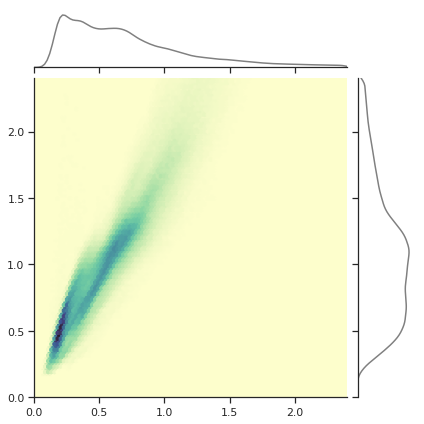

In [35]:
g = jointplot(2.*np.pi/86400./np.abs(ds.f)*np.sqrt(ds.uv_variance.sel(band='high'))/ds.u_rms , 
              ds.u_ageo_rms/ds.u_rms,
              (2.5,.1),(2.5,.1), log=False)

---

### linear regressions

In [27]:
lr = linear_model.LinearRegression(fit_intercept=False)
#lr = linear_model.LinearRegression(normalize=True)

In [53]:
lds = ds.stack(z=('i','j','face'))
# there are some outliers (large u_ageo_rms values):
lds = lds.where(lds.u_ageo_rms/lds.u_rms<10) 
#
lds = lds.dropna('z')
lds['uv_rms'] = np.sqrt(lds.u_rms**2+lds.v_rms**2)

distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [64]:
lds.band

<xarray.DataArray 'band' (band: 5)>
array(['semidiurnal', 'diurnal', 'inertial', 'subdiurnal', 'high'],
      dtype=object)
Coordinates:
  * band     (band) object 'semidiurnal' 'diurnal' ... 'subdiurnal' 'high'

In [69]:
#Xl = [2.*np.pi/86400./np.abs(lds.f)*np.sqrt(lds.uv_variance.sel(band='high'))]
Xl = [2.*2.*np.pi/86400./np.abs(lds.f)*np.sqrt(lds.uv_variance.sel(band='semidiurnal')),
      2.*np.pi/86400./np.abs(lds.f)*np.sqrt(lds.uv_variance.sel(band='diurnal')),
      np.sqrt(lds.uv_variance.sel(band='inertial')),
      lds.uv_rms**2/1e3/np.abs(lds.f)]
#X = np.stack(tuple([x.values.flatten() for x in Xl]),axis=1)
#y = (ds.u_ageo_rms/ds.u_rms).values.flatten()
#X = np.stack(tuple([x.stack(z=('i','j','face')).dropna('z').values for x in Xl]),axis=1)
#y = (ds.u_ageo_rms/ds.u_rms).stack(z=('i','j','face')).dropna('z').values
X = np.stack(tuple([x.values for x in Xl]),axis=1)
#y = (lds.u_ageo_rms/lds.u_rms).values
y = (lds.u_ageo_rms).values
print(X.shape)
print(y.shape)

distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 50% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 50% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 50% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 50% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

(1290055, 4)
(1290055,)


In [70]:
lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

In [71]:
lr.score(X,y)

0.7469557870695426

In [72]:
lr.coef_

array([1.17145449, 0.7871121 , 0.76109528, 0.00516094])

In [34]:
lr.normalize

False

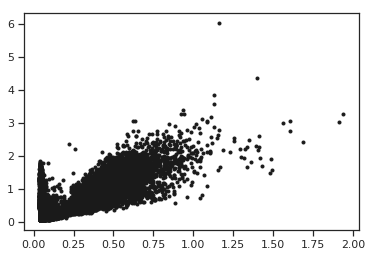

In [58]:
plt.plot(X[::10,:],y[::10],'k.')

---

### zonally average kinetic energy

In [ ]:
KE = np.sqrt((ds.ugeo_coriolis_linear**2+ds.vgeo_coriolis_linear**2))/np.abs(ds.f)
dlat = 1.
lat_edges = np.arange(-60.-dlat/2.,60.+dlat,dlat)
lat = lat_edges[:-1]+dlat/2.
KE_av = KE.groupby_bins('YC',lat_edges).mean()

In [ ]:
KE_av.plot()

---

In [21]:
w = cluster.scale(2)

In [22]:
client.restart()

Worker tcp://10.135.37.13:43395 restart in Job 2580660. This can be due to memory issue.
Worker tcp://10.135.36.90:40946 restart in Job 2581325. This can be due to memory issue.


Client Scheduler: tcp://10.135.39.90:40637 Dashboard: http://10.135.39.90:8787/status,Cluster Workers: 2 Cores: 16 Memory: 80.00 GB


In [26]:
cluster.close()